Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Getting real faces
Getting fake faces
Epoch 1/15
12/12 [==============================] - 1s 41ms/step - loss: 0.2458 - accuracy: 0.2430 - val_loss: 0.2470 - val_accuracy: 1.0000
Epoch 2/15
12/12 [==============================] - 0s 30ms/step - loss: 0.2428 - accuracy: 0.2430 - val_loss: 0.2440 - val_accuracy: 1.0000
Epoch 3/15
12/12 [==============================] - 0s 30ms/step - loss: 0.2399 - accuracy: 0.2430 - val_loss: 0.2411 - val_accuracy: 1.0000
Epoch 4/15
12/12 [==============================] - 0s 30ms/step - loss: 0.2370 - accuracy: 0.2430 - val_loss: 0.2382 - val_accuracy: 1.0000
Epoch 5/15
12/12 [==============================] - 0s 31ms/step - loss: 0.2341 - accuracy: 0.2430 - val_loss: 0.2353 - val_accuracy: 1.0000
Epoch 6/15
12/12 [==============================] - 0s 29ms/step - loss: 0.2312 - accuracy: 0.2430 - val_loss: 0.2324 - val_ac

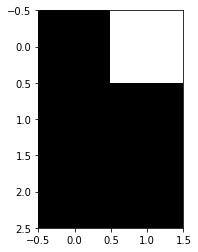

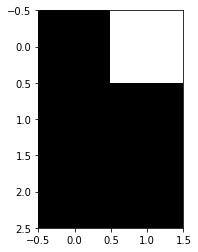

Testing fake faces
[0 1 0]
[1 1 0]
The feature maps for the fake faces



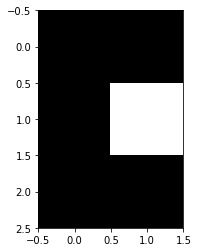

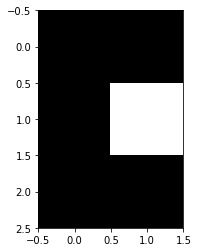

Testing face with CNN
feature maps for entire CNN


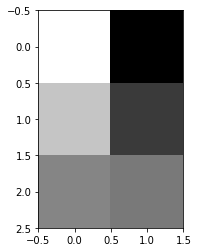

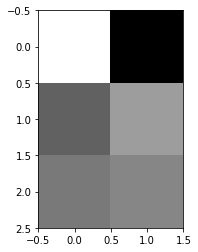

Fake faces


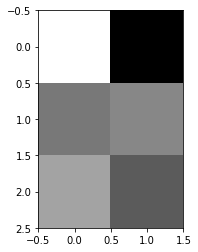

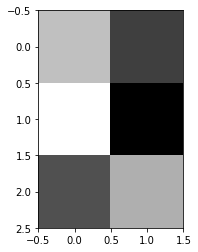

In [ ]:
import numpy as np
import math
import sys
import statistics
import tensorflow as tf
import string
import random
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
from tensorflow.python.framework import ops
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

drive.mount('/content/gdrive')

# NN for data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomWidth(0.1),
    layers.experimental.preprocessing.RandomHeight(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ])

d = tf.keras.models.load_model('/content/gdrive/My Drive/NewUnsupFaceTwo')
c = tf.keras.models.load_model('/content/gdrive/My Drive/OtherNewUnsupCNN')
modelDen = keras.models.Sequential()
modelCNN = keras.models.Sequential()

# all of this is hard coded. Sadness.
modelDen.add(d.layers[0])
modelDen.add(keras.layers.Dense(8))
modelDen.add(keras.layers.Activation('relu'))
modelDen.add(keras.layers.Dropout(0.4))
modelDen.add(keras.layers.Dense(2))  # fake or real face
modelDen.add(keras.layers.Activation('sigmoid'))


# CNN
modelCNN.add(c.layers[0])
modelCNN.add(keras.layers.Flatten())
modelCNN.add(keras.layers.Dropout(0.4))
modelCNN.add(keras.layers.Dense(2))  # fake or real face
modelCNN.add(keras.layers.Activation('softmax'))

x_train = []
x_test = []

y_train = []
y_test = []

x = []
y = []

realCount = 0
fakeCount = 0

x2 = []
y2 = []

z = []
a = []

print("Getting real faces")
for filename in glob.iglob(os.path.join('/content/gdrive/My Drive/realAndFake/real_and_fake_face/training_real/', "*.jpg")):
  img = Image.open(filename)
  img.thumbnail((128,128), Image.ANTIALIAS)
  img = img_to_array(img) 
  img = tf.image.rgb_to_grayscale(img)
  x.append(img)
  y.append([1.0])
  realCount += 1



print("Getting fake faces")
for filename in glob.iglob(os.path.join('/content/gdrive/My Drive/realAndFake/real_and_fake_face/training_fake/', "*.jpg")):
  img = Image.open(filename)
  img.thumbnail((128,128), Image.ANTIALIAS)
  img = img_to_array(img) 
  img = tf.image.rgb_to_grayscale(img)
  x.append(img)
  y.append([0.0])
  fakeCount += 1


x_train = x[:1428]
x_test = x[1428:]

y_train = y[:1428]
y_test = y[1428:]


'''ds_train = {}
ds_test = {}
ds_train = dict(zip(x_train, y_train))
ds_test = dict(zip(x_test, y_test))


temp = list(ds_train.keys)
random.shuffle(temp)
random.shuffle(temp)'''


y_test = ops.convert_to_tensor(y_test, dtype=tf.float32) / 255.00
y_train = ops.convert_to_tensor(y_train, dtype=tf.float32) / 255.00
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32) / 255.00
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32) / 255.00


######################### using a non pretrained model #############################

CNN_untrained = keras.models.Sequential(
    [
     keras.layers.Input((128, 128, 1)),
     keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
     keras.layers.MaxPool2D(pool_size=(2,2)),
     keras.layers.Conv2D(24, kernel_size=(3,3), activation='relu'),
     keras.layers.MaxPool2D(pool_size=(2,2)),
     keras.layers.Dropout(0.2),
     keras.layers.Flatten(),
     keras.layers.Dense(2, activation='softmax')
    ]
)



# batch size of 128 gave some close answers w/ MSE() w/ epochs=45
modelDen.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics='accuracy')
modelDen.fit(x=x_train, y=y_train, shuffle=True, batch_size=128, epochs=15, validation_data=(x_test, y_test))
#modelDen.save('/content/gdrive/My Drive/fake-RealDense')


print("================================================")
print("================================================")
print("================================================")
print("Training CNN model now.\n")

modelCNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics='accuracy')
modelCNN.fit(x=x_train, y=y_train, shuffle=True, batch_size=128, epochs=10, validation_data=(x_test, y_test))
#modelCNN.save('/content/gdrive/My Drive/fake-RealCNN')


print("================================================")
print("================================================")
print("================================================")
print("Training Untrained model now.\n")

CNN_untrained.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError(), metrics='accuracy')
CNN_untrained.fit(x=x_train, y=y_train, shuffle=True, batch_size=128, epochs=30, validation_data=(x_test, y_test))


################ Predictions begin here ################


print("Testing real faces")
imgWoman = load_img('/content/gdrive/My Drive/test2.jpg', target_size=(128, 128))
imgMan = load_img('/content/gdrive/My Drive/test3.jpg', target_size=(128, 128))

imgWoman = img_to_array(imgWoman)
imgMan = img_to_array(imgMan)

imgWoman = imgWoman.reshape(-1, 128, 128, 1)
imgMan = imgMan.reshape(-1, 128, 128, 1)

feature_mapsW = modelDen.predict(imgWoman)
feature_mapsM = modelDen.predict(imgMan)
print(np.argmax(feature_mapsM, axis = 1))
print(np.argmax(feature_mapsW, axis = 1))

print("The feature maps for the real faces\n")
pyplot.imshow(feature_mapsW[:,:], cmap='gray')
pyplot.show()
pyplot.imshow(feature_mapsM[:,:], cmap='gray')
pyplot.show()


print("Testing fake faces")
fake1 = load_img('/content/gdrive/My Drive/1-detectingfak.jpg', target_size=(128, 128))
fake2 = load_img('/content/gdrive/My Drive/image2.jpg', target_size=(128, 128))

img1 = img_to_array(fake1)
img2 = img_to_array(fake2)

img1 = img1.reshape(-1, 128, 128, 1)
img2 = img2.reshape(-1, 128, 128, 1)

feature_maps1 = modelDen.predict(img1)
feature_maps2 = modelDen.predict(img2)

print(np.argmax(feature_maps1, axis = 1))
print(np.argmax(feature_maps2, axis = 1))

print("The feature maps for the fake faces\n")
pyplot.imshow(feature_maps1[:,:], cmap='gray')
pyplot.show()
pyplot.imshow(feature_maps2[:,:], cmap='gray')
pyplot.show()





print("Testing face with CNN")
feature_mapCNN = modelCNN.predict(imgWoman)
feature_mapCNN2 = modelCNN.predict(imgMan)
feature_mapCNN3 = modelCNN.predict(img1)
feature_mapCNN4 = modelCNN.predict(img2)

print("feature maps for entire CNN")
pyplot.imshow(feature_mapCNN[:,:], cmap='gray')
pyplot.show()
pyplot.imshow(feature_mapCNN2[:,:], cmap='gray')
pyplot.show()
print("Fake faces")
pyplot.imshow(feature_mapCNN3[:,:], cmap='gray')
pyplot.show()
pyplot.imshow(feature_mapCNN4[:,:], cmap='gray')
pyplot.show()